In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential

In [2]:
# Load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split)

### Enter your tag as unique id for saving

In [3]:
import time
timestr = time.strftime("%d%m%Y")
tag = str("sQNN-"+timestr)

0: ─╭AngleEmbedding(M0)─╭BasicEntanglerLayers(M1)─┤  <Z>
1: ─├AngleEmbedding(M0)─├BasicEntanglerLayers(M1)─┤  <Z>
2: ─├AngleEmbedding(M0)─├BasicEntanglerLayers(M1)─┤  <Z>
3: ─├AngleEmbedding(M0)─├BasicEntanglerLayers(M1)─┤  <Z>
4: ─╰AngleEmbedding(M0)─╰BasicEntanglerLayers(M1)─┤  <Z>


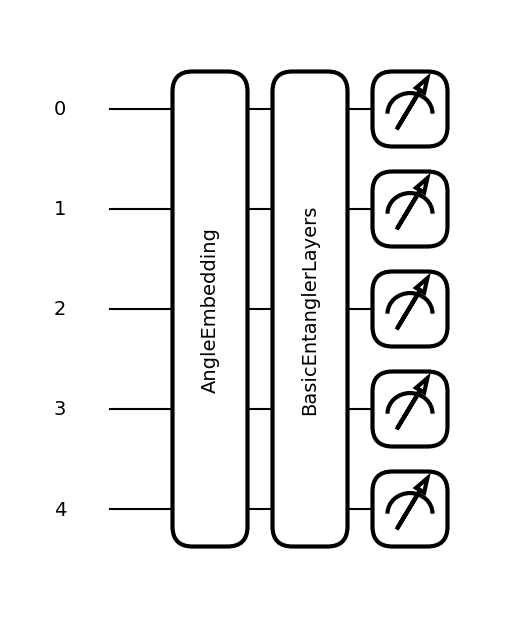

In [4]:
from pennylane import numpy as np
# In a first try, we use as much qubits as we have input params
n_qubits = x_train.shape[1]
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}
n_qcParams = n_layers*n_qubits

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='X')
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits), rotation=qml.RX)
    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

print(qml.draw(qnode)(x_train[0,:],np.random.rand(n_layers,n_qubits)))
fig1, ax = qml.draw_mpl(qnode)(x_train[0,:],np.random.rand(n_layers,n_qubits))
plt.show()
fig1.savefig("archive/Qnode-"+tag+".png")
fig1.savefig("archive/Qnode-"+tag+".pdf")

In [5]:
#Create a simple ANN
clear_session()
layer_0 = Input(shape=(x_train.shape[1],))
layer_1 = Dense(5, activation="relu")
layer_2 = Dense(5, activation="linear")
ann = Sequential([layer_0, layer_1, qlayer, layer_2])
print(f"Params in the quantum layer to train: {n_qcParams}")
ann.summary()

plot_model(ann)

Params in the quantum layer to train: 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 keras_layer (KerasLayer)    (None, 5)                 0 (unused)
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
#Training
opt = tf.keras.optimizers.RMSprop(learning_rate=0.2)
ann.compile(opt, loss='mean_squared_error', metrics=['mean_absolute_error'])
ann_history = ann.fit(x_train, y_train, epochs=50, batch_size=25, validation_split=0.25)

Epoch 1/50
31/31 [==============================] - 340s 11s/step - loss: 13634.5977 - mean_absolute_error: 116.4448 - val_loss: 10845.8389 - val_mean_absolute_error: 103.9239
Epoch 2/50
31/31 [==============================] - 361s 12s/step - loss: 8646.6807 - mean_absolute_error: 92.4922 - val_loss: 7185.8198 - val_mean_absolute_error: 84.3895
Epoch 3/50
31/31 [==============================] - 387s 13s/step - loss: 5129.4346 - mean_absolute_error: 70.9774 - val_loss: 4324.8228 - val_mean_absolute_error: 65.3887
Epoch 4/50
31/31 [==============================] - 436s 14s/step - loss: 2614.9905 - mean_absolute_error: 49.5069 - val_loss: 857.7889 - val_mean_absolute_error: 28.3706
Epoch 5/50
31/31 [==============================] - 316s 10s/step - loss: 1142.8265 - mean_absolute_error: 28.1278 - val_loss: 139.5413 - val_mean_absolute_error: 10.2393
Epoch 6/50
31/31 [==============================] - 323s 10s/step - loss: 79.0586 - mean_absolute_error: 7.3887 - val_loss: 52.5513 - val_

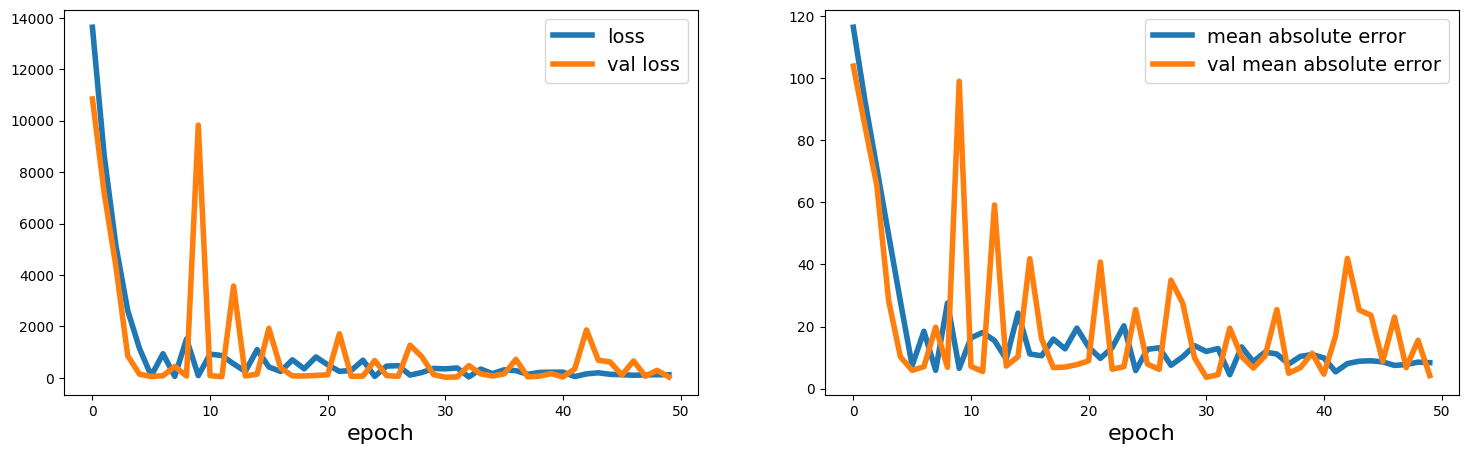

In [7]:
import numpy as np
def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(ann_history)

KeyError: 'lr'

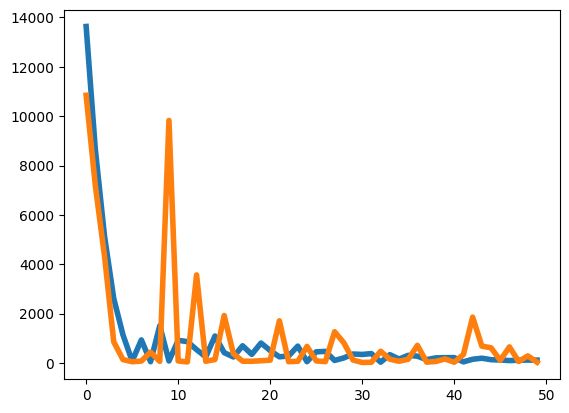

In [8]:
fig = plt.figure()
plt.plot(ann_history.history['loss'], lw=4, label='loss')
plt.plot(ann_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(ann_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/history-"+tag+".png")

In [ ]:
evaluation = ann.evaluate(x_test[:-1], y_test[:-1])

16/16 [==============================] - 82s 5s/step - loss: 77.4277 - mean_squared_error: 77.4277 - mean_absolute_error: 7.1178


In [ ]:
ann.save("archive/model-"+tag+".h5")
config = ann.get_config()
np.save("archive/config-"+tag+".npy", config)